Time-series forecasting from IoT Home Automation Data.

Tuomas Eerola - 2019

Data source: https://github.com/eerolat/home-automation-data-logger

# Run either of the following cells.

This will to connect you to the data:


1.   Some test data from the Internet; or
2.   the actual sensor data.


Run the following cell to use test data from the Internet. 

In [186]:
import pandas as pd

from urllib.request import urlopen

log_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

url = urlopen(log_url)

series_example = pd.read_csv(log_url, header=0, parse_dates=[0])
series_example.columns=['Date Time', 'Temp']

series = series_example.drop_duplicates(subset='Date Time', keep='last')
series = series.set_index('Date Time')
series = series.resample('H').interpolate()

print ("Data loading ready.")

Data loading ready.


Run the following cell to use actual sensor data. 

In [192]:
import pandas as pd

from urllib.request import urlopen

log_url = "http://eerola.dy.fi/temp/temperature.log"

series_own = pd.read_csv(log_url, sep=" ", parse_dates=[[0, 1]])
series_own.columns=['Date Time', 'SourceInfo1', 'SourceInfo2', 'MeasurementInfo1', 'Temp', 'MeasurementInfo2', 'Measurement2']
#series_own.insert(6, "Target", "NaN")
dropcolumns = ['SourceInfo1', 'SourceInfo2', 'MeasurementInfo1', 'MeasurementInfo2', 'Measurement2']
series_own.drop(dropcolumns, inplace=True, axis=1)
series_own.set_index('Date Time', inplace=True)

series = series_own.reset_index()
series = series.drop_duplicates(subset='Date Time', keep='last')
series = series.set_index('Date Time')
series = series.resample('H').bfill()

print ("Data loading ready.")

Data loading ready.


# Visualize the data to see what we've got.

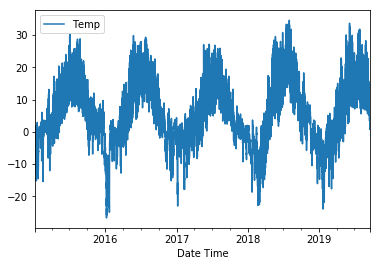

In [193]:
from matplotlib import pyplot


series.plot()
pyplot.show()

# Let's run a forecast.

In [0]:
forecast_days = 5

Let's fit the forecast model...

In [195]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import datetime

model = ARIMA(series, order=(4,0,2))
model_fit = model.fit(disp=0)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


...and run the forecast.

In [0]:
start_index = series.index[-1]
end_index = start_index + datetime.timedelta(forecast_days)
forecast = model_fit.predict(start=start_index, end=end_index)

Now we can visualize our data.

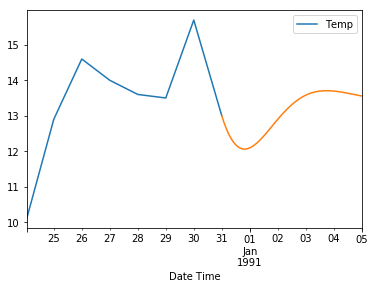

In [191]:
from matplotlib import pyplot


series.last('7D').plot()
forecast.plot()
pyplot.show()

In [130]:
series

,Temp
Date Time,
1981-01-01 00:00:00,20.7
1981-01-01 01:00:00,17.9
1981-01-01 02:00:00,17.9
1981-01-01 03:00:00,17.9
1981-01-01 04:00:00,17.9
1981-01-01 05:00:00,17.9
1981-01-01 06:00:00,17.9
1981-01-01 07:00:00,17.9
1981-01-01 08:00:00,17.9


# We can compare the forecast to current data.

In [0]:
print(dataset.tail(1))

                      Temp
Date Time                 
2019-09-14 05:00:00  6.845


In [0]:
print(validation.head(12))

                      Temp
Date Time                 
2019-09-14 06:00:04   6.56
2019-09-14 06:30:04   6.63
2019-09-14 07:00:04   6.56
2019-09-14 07:30:04   6.19
2019-09-14 08:00:03   6.63
2019-09-14 08:30:04   8.25
2019-09-14 09:00:04   9.13
2019-09-14 09:30:03   9.69
2019-09-14 10:00:04  10.25
2019-09-14 10:30:04  10.88
2019-09-14 11:00:05  11.50
2019-09-14 11:30:04  11.94
